# Regression and Model Selection

In this notebook I will demonstrate my understanding of overfitting and underfitting using regression as an example. First I will generate a 1-dimensional feature space and an array of values for each row in the feature space. Then I will create regresion estimators based on linear regression (`x**1`) and polynomial regression (2nd, 4th and 6th degree, i.e. `x**2`, `x**4`  and `x**6`). I will show that the higher the polynomial, the better the fit for the train set, but the worse the fit for the test set. I will visually support my case.

I will re-use code from the [Python Data Science Handbook](http://bit.ly/2y3xzKw). To proof my understanding of the code I am re-using, I will comment on the code in my own words, both in MarkDown cells and in frequent code comment.

## 1. create test data

In order to learn about over- and underfitting by using numpy and scikit, some form of test data is required. This can be created randomly.

In [11]:
import numpy as np

def make_data(N, err=1.0, rseed=1):
    # randomly sample the data using a seed to ensure that the same random data is used every time.
    # this makes comparisons and discussions easier.
    rng = np.random.RandomState(rseed)
    # generate random feature array of floats between 0 and 1, square them
    X = rng.rand(N, 1) ** 2
    # create target array from feature array
    y = 10 - 1. / (X.ravel() + 0.1)
    # put some errors (or rather uncertainty) into the target array
    if err > 0:
        y += err * rng.randn(N)
    return X, y

X, y = make_data(50) # create 500 points of test data

## 2. create the regression pipeline

[your comment goes here]

In [12]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), 
                         LinearRegression(**kwargs))

## 3. show the regressors

the deciding factor to find a point that neither over- nor underfits the model is the degree of the Polynomial regression:

More complex curves adapt better to the training set but may yield insufficiently accurate results in the test data.

Less complex curves on the other hand may not accurately account for the learning data.

The code below shows the lines drawn by a selection of regressor values.

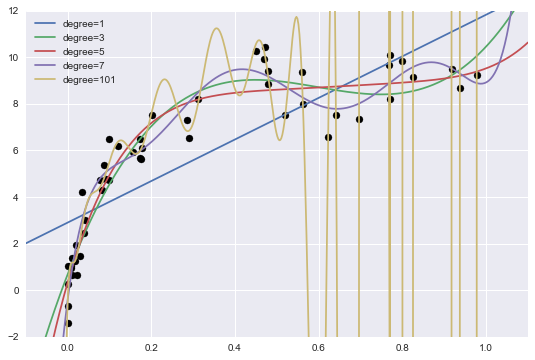

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [9, 6]
import seaborn
seaborn.set()

# get 500 test values between 0.1 and 1.1
X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.scatter(X.ravel(), y, color='black') # plot the data to analyse
axis = plt.axis()
for degree in [1, 3, 5, 7, 101]:
    y_model = PolynomialRegression(degree) # get model to work with
    y_fit = y_model.fit(X, y) # fit learning data
    y_test = y_fit.predict(X_test) # predict test data
    plt.plot(X_test.ravel(), y_test, label='degree={}'.format(degree))

# plot formatting
plt.xlim(-0.1, 1.1)
plt.ylim(-2, 12)
plt.legend(loc='best')

The plot above shows four "normal" regressors (degrees 1, 3, 5 and 7) as well as an extreme example (degree 101).

I expect the regressor of degree 1 to have a low score in both the learning and test data validation and the regressor of degree 101 to score very well for learn data validation while scoring badly for the test data.

I expect the best results from degrees 3, 5 or 7, hopefully one of them yields values that are neither over- nor underfit.

## 4. show the validation curve

While testing several degrees manually is possible, it is easier to automate this step using the scikit learning curve funcitonality.

It plots scores for training and validation based on the data set for as many degrees as desired.

c:\users\nwalter\appdata\local\programs\python\python35\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
c:\users\nwalter\appdata\local\programs\python\python35\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


(0, 1)

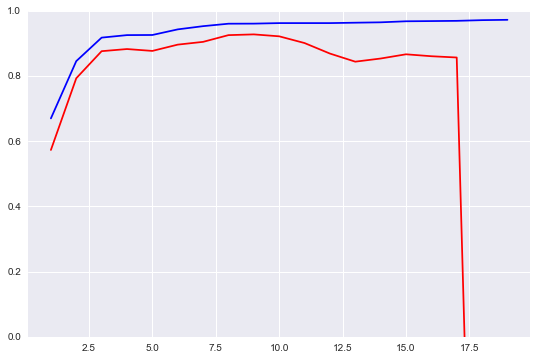

In [14]:
from sklearn.learning_curve import validation_curve
degree = np.arange(1, 20)

# basically this iterates over the "degree" list and for each degree finds
# the score for both training and test data set
# cv=7 sets the cross validation value to divide the sets into seven
# partitions to test with
train_score, val_score = validation_curve(PolynomialRegression(),
                                          X, y,
                                         "polynomialfeatures__degree",
                                         degree, cv=7)
# both train_score and val_score are now lists of lists of seven scores
# (one of each cross validation partition)

# plot the median of the cross validation scores using degree on the x axis
plt.plot(degree, np.median(train_score, 1), color="blue", label="training score")
plt.plot(degree, np.median(val_score, 1), color="red", label="validation score")

# limit the plot because otherwise it is more or less unusable
plt.ylim(0, 1) # use for size 50 test data
#plt.ylim(0.8, 0.91) # use for size 500 test data

The graph above shows the accuracy (y-axis) in relation to the polynomial degree used. The blue lines shows the score for the training data, the red line for the validation data.

What it shows is that the accuracy for the training data consistently increases with the polynomial degree used. Validation data on the other hand rises only to a certain point and once a second limit has been stepped over it falls of rapidly.

This is the point at which overfitting occured.

## 5. conduct grid search to find the optimal regressor

The point of the effort done above was to find the degree at which the regressor will yield optimal results. this means that it is neither over- nor underfit: the validation score should be at its highest point, but the training score should not be too low either.

In [15]:
t_med = np.median(train_score, 1)
v_med = np.median(val_score, 1)

t_hi = 0
v_hi = 0
for i in range(len(t_med)):
    if t_med[i] > t_med[t_hi]:
        t_hi = i
    if v_med[i] > v_med[v_hi]:
        v_hi = i

print("highest train score: {} at index {}".format(t_med[t_hi], t_hi))
print("highest validation score: {} at index {}".format(v_med[v_hi], v_hi))

highest train score: 0.9718631856436476 at index 18
highest validation score: 0.9271922768408036 at index 8


Because the plot (on my machine) is very small and it is hard to get detailed results, i printed the numbers as well.

It is obvious that the training score is rising steadily with higher degrees.

At the same time, the validation score has its peak at degree 8. Higher values lower the score slowly at first but more rapidly the higher it goes.

The above was generated using a test set of size 50.

At a test size of 500, the degree with the highest validation score is 7 instead of 8, the learning data score shows the same general form as with a smaller size.